In [6]:
%%writefile ../modules/environment.py
import numpy as np
from typing import *


class Environment:
    def __init__(self, env_size: int, n_enemy: int = 1) -> None:
        self.env_size = env_size
        self.n_enemy = n_enemy
        self.reset()

    def reset(self):
        self.food = np.random.randint(self.env_size, size=2)
        self.enemies = [np.random.randint(
            self.env_size, size=2) for _ in range(self.n_enemy)]
        while True:
            self.player = np.random.randint(
                self.env_size, size=2)  # need to fix
            self.get_reward_and_done()  # update self._done
            if not self._done:  # self._done == False
                break

        return self.state

    @property
    def state(self):
        def make_string(xy): return str(xy[0])+"_"+str(xy[1])
        order_enem = sorted([tuple(coordinate) for coordinate in self.enemies])
        return "-".join(
            list(
                map(
                    make_string,
                    [self.player, self.food, *order_enem]
                )
            )
        )

    def render(self):
        grid = np.zeros((self.env_size, self.env_size), dtype=int)
        # 1 : player
        # 2 : food
        # 3 : enemy
        p = tuple(self.player)
        f = tuple(self.food)
        grid[p] = 1
        grid[f] = 2
        if f == p:
            grid[f] = 5
        for enemy in self.enemies:
            e = tuple(enemy)
            if e == f and f == p:
                grid[e] = 7
            elif e == f:
                grid[e] = 4
            elif e == p:
                grid[e] = 6
            else:
                grid[e] = 3

        return grid

    def __repr__(self):
        grid = self.render()
        repr = {0: " ", 1: "P", 2: "F", 3: "E", 4: "?", 5: "@", 6: "X", 7: "#"}
        result = " " + "-"*self.env_size + "\n"
        for row in grid:
            row_string = "|"
            for col in row:
                row_string += repr[col]
            row_string += "|\n"
            result += row_string
        result += " " + "-"*self.env_size
        return result

    @property
    def done(self):
        return self._done

    def step(self, palyer_direction):
        # move player
        self.move("player", palyer_direction)

        # always move enemies randomly
        for i in range(self.n_enemy):
            enemy_direction = np.random.randint(1, 5)
            self.move(f"enemy{i}", enemy_direction)

        # get reward after a step
        reward, done = self.get_reward_and_done()
        next_state = self.state
        return reward, next_state, done

    def move(self, entity_name, direction):
        if entity_name == "player":
            entity = self.player
        elif "enemy" in entity_name:
            e_index = int(entity_name[5:])
            entity = self.enemies[e_index]
        else:
            raise ValueError(f"Invalid entity_name {entity_name}")

        if direction == 0:  # do not move
            pass
        elif direction == 1:  # left
            # not allowed to go out of the wall
            entity[1] = max(0, entity[1] - 1)
        elif direction == 2:  # right
            # not allowed to go out of the wall
            entity[1] = min(self.env_size - 1, entity[1] + 1)
        elif direction == 3:  # up
            # not allowed to go out of the wall
            entity[0] = max(0, entity[0] - 1)
        elif direction == 4:  # down
            # not allowed to go out of the wall
            entity[0] = min(self.env_size - 1, entity[0] + 1)

    def get_reward_and_done(self):
        reward = 0
        done = False
        if np.all(self.player == self.food):
            reward += 1
            done = True
        for enemy in self.enemies:
            if np.all(self.player == enemy):
                reward -= 1
                done = True
        self._done = done
        return reward, done


Overwriting ../modules/environment.py


In [2]:
%%writefile ../modules/utils.py
import numpy as np
import json


def save_to_json(data, path):
    with open(path, "w") as json_file:
        dumped = {state: qvalue.tolist() for state, qvalue in data.items()}
        json.dump(dumped, json_file, indent=3)


def read_from_json(path):
    with open(path, "r") as json_file:
        content = json.load(json_file)
    data = {state: np.array(qvalue) for state, qvalue in content.items()}
    return data


Overwriting ../modules/utils.py


In [3]:
%%writefile ../modules/agent.py
from modules.utils import save_to_json, read_from_json
import numpy as np


class QAgent:
    def __init__(self, num_actions, gamma, learning_rate, epsilon, qfunction=None) -> None:
        self.n_actions = num_actions
        self.qfunction = {} if qfunction is None else qfunction if isinstance(
            qfunction, dict) else read_from_json(qfunction)
        self.gamma = gamma
        self.alpha = learning_rate
        self.epsilon = epsilon

    def act(self, state, eval=False):
        if state not in self.qfunction:
            self.qfunction[state] = np.zeros(self.n_actions)
        u = np.random.uniform()
        if eval or self.epsilon < u:
            action = np.argmax(self.qfunction[state])
        else:
            action = np.random.randint(self.n_actions)
        return action

    def update(self, state, action, reward, next_state, done):
        if state not in self.qfunction:
            self.qfunction[state] = np.zeros(self.n_actions)

        if done:
            self.qfunction[state][action] = (
                1 - self.alpha)*self.qfunction[state][action] + self.alpha*reward
        else:
            if next_state not in self.qfunction:
                self.qfunction[next_state] = np.zeros(self.n_actions)
            self.qfunction[state][action] = (1 - self.alpha)*self.qfunction[state][action] + \
                self.alpha*(reward + self.gamma *
                            self.qfunction[next_state].max())

    def save_qfunction(self, path="./qfunction.json"):
        save_to_json(self.qfunction, path)

    def load_qfunction(self, path="./qfunction.json"):
        self.qfunction = read_from_json(path)


Overwriting ../modules/agent.py


In [4]:
%%writefile ../modules/train.py
from modules.environment import Environment
from modules.agent import QAgent
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def run_episode(env: Environment, agent: QAgent, max_step: int, eval: bool, show=False):
    state = env.reset()
    actions_name = {0: "halt", 1: "left", 2: "right", 3: "up", 4: "down"}
    n_step = 1
    if show:
        print(
            "Symbols meaning [P: Player/Agent, E: enemy, F: food/goal, ?: E+F, @: P+F, X: P+E, #: P+E+F]")
        print("New Environment :")
        print(env)
    while True:
        action = agent.act(state, eval)
        reward, next_state, done = env.step(action)
        if show:
            print(
                f"action : {actions_name[action]} is taken at step: {n_step}\n")
            print(env)
        if not eval:
            agent.update(state, action, reward, next_state, done)
        state = next_state
        n_step += 1
        if done or n_step > max_step:
            break

    return reward


def train(environment: Environment, agent: QAgent, num_episode: int, max_step: int = 1000):
    rewards = []
    episodes = []
    eval_every = 10
    n_eval = 5
    try:
        for ep in tqdm(range(1, num_episode+1)):
            run_episode(environment, agent, max_step, eval=False, show=False)
            if ep % 10 == 0:
                episodes.append(ep)
                mean_reward = np.mean([run_episode(
                    environment, agent, max_step, eval=True, show=False) for _ in range(n_eval)])
                rewards.append(mean_reward)
    except KeyboardInterrupt:
        print(f"Training interrupted at {ep} episodes.")
        input("Press enter to continue ...")

    return episodes, rewards


def plot_rewards(episodes, rewards):
    plt.figure(figsize=(10, 5))
    plt.title("Average reward during training.")
    plt.plot(episodes, rewards, "g:", label="average reward")
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.legend()
    plt.show()


Overwriting ../modules/train.py


In [5]:
%%writefile ../generate-qfunction.py
#!/usr/bin/env python3

from modules.environment import Environment
from modules.agent import QAgent
from modules.train import train, plot_rewards, run_episode

from argparse import ArgumentParser

parser = ArgumentParser(
    description="Generate a qvalue function in a json file.")

parser.add_argument("-n", "--env-size", type=int,
                    help="size of the environment")
parser.add_argument("-en", "--n-enem", type=int,
                    help="number of enemy in the evironment")
parser.add_argument("-g", "--gamma", type=float,
                    help="discount factor (horizon-size)")
parser.add_argument("-lr", "--learning-rate", type=float,
                    help="learning rate/alpha (exploitation)")
parser.add_argument("-eps", "--epsilon", type=float,
                    help="probability to act non-greedy (exploration)")
parser.add_argument("-epi", "--n-episode", type=int,
                    help="number of episodes for training")
parser.add_argument("-max", "--max-step", type=int,
                    help="maximum number of steps for each episode")
parser.add_argument("-l", "--path-to-load-qfunction", type=str,
                    help="path for the json file of qvalue function to load")
parser.add_argument("-s", "--path-to-save-qfunction", type=str,
                    help="path for the json file of qvalue function to save")
parser.add_argument("-show", "--show", type=bool,
                    help="flag either user want to show the reward during training")


args = vars(parser.parse_args())

env_size = args["env_size"]
n_enem = args.get("n_enem",1)
num_actions = 5
gamma = args["gamma"]
learning_rate = args["learning_rate"]
epsilon = args["epsilon"]
n_episode = args["n_episode"]
max_step = args["max_step"]
path_load_qfunction = args.get("path_to_load_qfunction", None)
path_save_qfunction = args.get(
    "path_to_save_qfunction", None)
show_plot = args.get("show", False)


env = Environment(env_size=env_size, n_enemy=n_enem)
agent = QAgent(num_actions=num_actions, gamma=gamma,
               learning_rate=learning_rate, epsilon=epsilon, qfunction=path_load_qfunction)
print("Start trainining...")
episodes, rewards = train(environment=env, agent=agent,
                          num_episode=n_episode, max_step=max_step)
print("Training done successfully.")
if path_save_qfunction is not None:
    agent.save_qfunction(path_save_qfunction)
if show_plot:
    plot_rewards(episodes, rewards)


Overwriting ../generate-qfunction.py


In [7]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [8]:
from modules.environment import Environment
from modules.agent import QAgent
from modules.train import train, plot_rewards, run_episode

In [15]:
env_size = 5
n_enem = 3
num_actions = 5
gamma = 0.999
learning_rate = 0.001
epsilon = 1
n_episode = 1000000
max_step = 1000
path_save_qfunction = f"../qfunction/qfunction-size{env_size}_enem{n_enem}.json"
path_load_qfunction = path_save_qfunction
show_plot = True

Start trainining...


100%|██████████| 1000000/1000000 [06:34<00:00, 2534.46it/s]


Training done successfully.


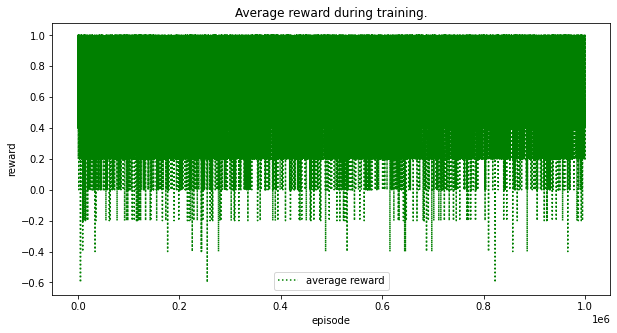

In [16]:
env = Environment(env_size=env_size, n_enemy=n_enem)
agent = QAgent(num_actions=num_actions, gamma=gamma,
               learning_rate=learning_rate, epsilon=epsilon, qfunction=path_load_qfunction)

print("Start trainining...")
episodes, rewards = train(environment=env, agent=agent,
                          num_episode=n_episode, max_step=max_step)
print("Training done successfully.")

agent.save_qfunction(path_save_qfunction)
if show_plot:
    plot_rewards(episodes, rewards)


In [17]:
env = Environment(env_size=env_size, n_enemy=n_enem)
agent = QAgent(num_actions=num_actions, gamma=gamma,
               learning_rate=learning_rate, epsilon=epsilon, qfunction=path_save_qfunction)


In [18]:
reward = run_episode(env,agent, max_step, eval=True, show=True)
print(f"Final reward : {reward}")

Symbols meaning [P: Player/Agent, E: enemy, F: food/goal, ?: E+F, @: P+F, X: P+E, #: P+E+F]
New Environment :
 -----
|   F |
|     |
|  PE |
| E   |
|    E|
 -----
action : up is taken at step: 1

 -----
|   F |
|  PE |
|     |
|     |
| E  E|
 -----
action : up is taken at step: 2

 -----
|  P? |
|     |
|     |
|     |
| E E |
 -----
action : right is taken at step: 3

 -----
|   @E|
|     |
|     |
| E   |
|  E  |
 -----
Final reward : 1
